In [118]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

from pyfusion.data import load

In [119]:
SLICE = 70
KERNEL_SIZE = 3
NOISE_SCALE = 0.2   # sigma
INTEGRATION_SCALE = 10   # rho
ALPHA = 0.001

ITERATIONS = 10
STEP_SIZE = 0.01

In [120]:
def gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Generate a Gaussian kernel.
    """
    return np.exp(-(x**2 + y**2) / (2 * std_dev**2)) / (2 * np.pi * std_dev**2)


def dx_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to x.
    """
    return -x * gaussian(std_dev, x, y) / (std_dev**2)


def dy_gaussian(std_dev: float, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of a Gaussian kernel with respect to y.
    """
    return -y * gaussian(std_dev, x, y) / (std_dev**2)

def lambda_func(mu_1, mu_2):
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1-ALPHA) * np.exp(-1/(mu_1 - mu_2)**2)

In [121]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [122]:
FSL = load.load_fsl("../data/example_mri", SLICE)
FA_noisy = FSL.FA + 0.2 * FSL.FA.std() * np.random.randn(*FSL.FA.shape)

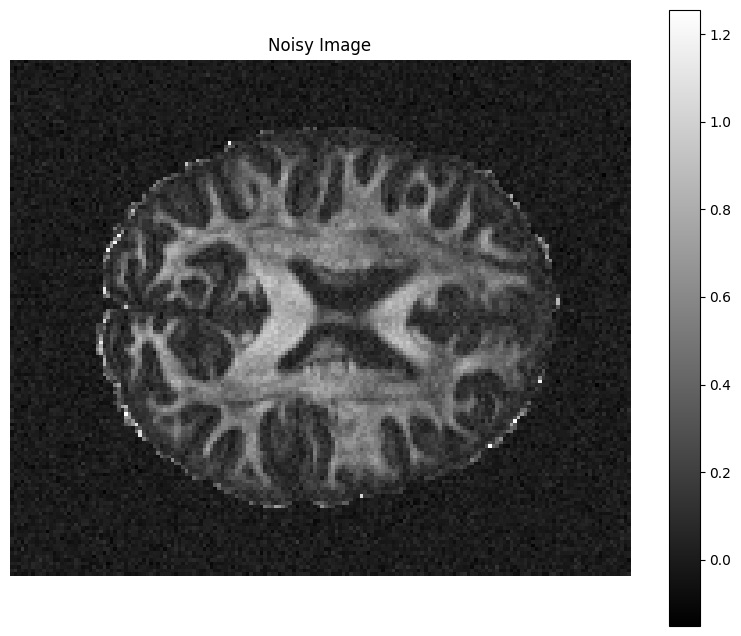

In [123]:
plot(FA_noisy, title="Noisy Image")

In [124]:
# load the eigenvectors and eigenvalues
eigvec_1, eig_val_1 = FSL.V1, FSL.L1
eigvec_2, eig_val_2 = FSL.V2, FSL.L2
eigvec_3, eig_val_3 = FSL.V3, FSL.L3

In [125]:
V = np.stack((eigvec_1, eigvec_2, eigvec_3), axis=-1)
Lambda = np.stack((eig_val_1, eig_val_2, eig_val_3), axis=-1)
V_scaled = V * Lambda[..., np.newaxis, :]
tensor_field = np.matmul(V_scaled, np.swapaxes(V, -1, -2))
tensor_field = tensor_field[..., :2, :2]

In [126]:
a = tensor_field[..., 0, 0]
b = tensor_field[..., 0, 1]
c = tensor_field[..., 1, 1]

We are calculating the space dependent stencil via

$$
D= \begin{bmatrix}
A & B & C \\
D & E & F \\
G & H & I
\end{bmatrix}
$$

With $A_{i,j} = \frac{1}{4} \cdot b_{i-1,j}-b_{i,j+1}$

In [127]:
a_padded = np.pad(a, pad_width=1, mode="symmetric")
b_padded = np.pad(b, pad_width=1, mode="symmetric")
c_padded = np.pad(c, pad_width=1, mode="symmetric")

In [128]:
A = (1/4) * (b_padded[0:-2, 1:-1] - b_padded[1:-1, 2:])  # b_i-1,j - b_i,j+1
B = (1/2) * (c_padded[1:-1, 2:] + c_padded[1:-1, 1:-1]) # c_i,j+1 + c_i,j
C = (1/4) * (b_padded[2:, 1:-1] + b_padded[1:-1, 2:])   # b_i+1,j + b_i,j+1
D = (1/2) * (a_padded[0:-2, 1:-1] + a_padded[1:-1, 1:-1])   # a_i-1,j + a_i,j
E = -(1/2) * (a_padded[0:-2, 1:-1] + 2*a_padded[1:-1, 1:-1] + a_padded[2:, 1:-1] + c_padded[1:-1, 0:-2] + 2 * c_padded[1:-1, 1:-1] + c_padded[1:-1, 2:])  # a_i-1,j + 2*a_i,j + a_i+1,j + c_i,j-1 + 2*c_i,j + c_i,j+1
F = (1/2) * (a_padded[2:, 1:-1] + a_padded[1:-1, 1:-1])
G = (1/4) * (b_padded[0:-2, 1:-1] + b_padded[1:-1, 0:-2])   # b_i-1,j + b_i,j-1
H = (1/2) * (c_padded[1:-1, 0:-2] + c_padded[1:-1, 1:-1])   # c_i,j-1 + c_i,j
I = (1/4) * (b_padded[2:, 1:-1] - b_padded[1:-1, 0:-2])  # b_i+1,j - b_i,j-1

Stencil = np.stack([
    np.stack([A, B, C], axis=-1),
    np.stack([D, E, F], axis=-1),
    np.stack([G, H, I], axis=-1)
], axis=-2)

In [129]:
img = FA_noisy.copy()
n, m = img.shape

Id = np.eye(3)
w_stencil = Id + STEP_SIZE * Stencil

for i in range(ITERATIONS):
    img_padded = np.pad(img, pad_width=1, mode='symmetric')

    neighborhoods = np.lib.stride_tricks.sliding_window_view(img_padded, (3,3))

    img = np.sum(w_stencil * neighborhoods, axis=(-2, -1))

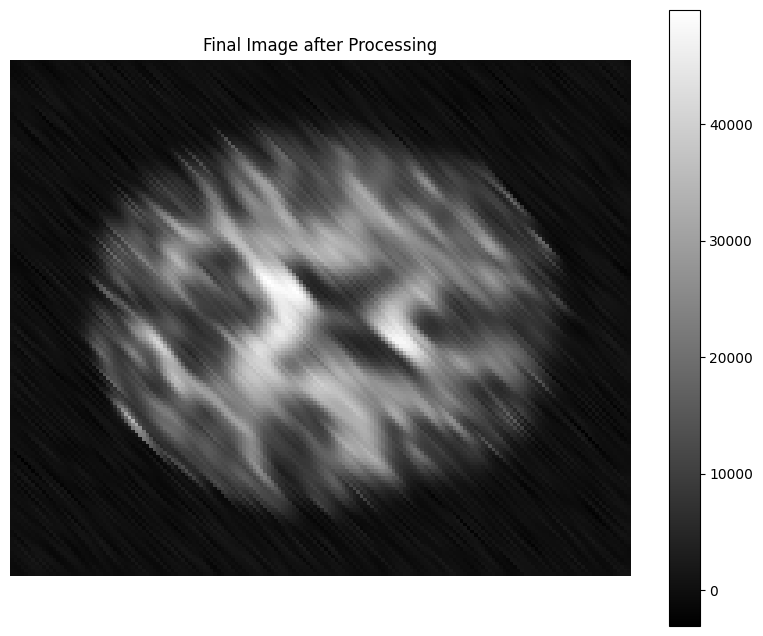

In [130]:
plot(img, title="Final Image after Processing")

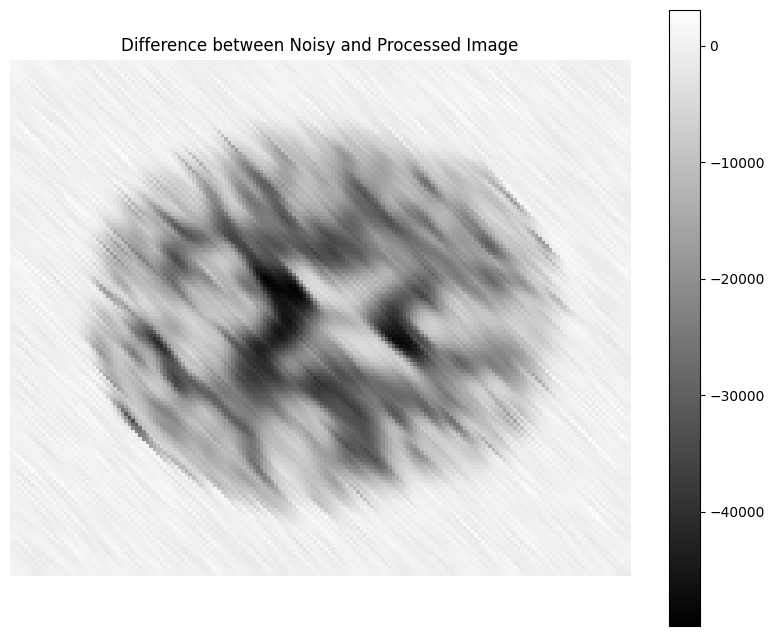

In [131]:
plot(FA_noisy-img, title="Difference between Noisy and Processed Image")

In [132]:
# stats
np.std(FA_noisy - img)

np.float64(10617.588694604565)